In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython import display as ds
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
import math

%matplotlib inline

/home/kvpcloud/.conda/envs/p3_gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class Dataset:
    main = 'dataset/UCSD_Anomaly_Dataset.v1p2'
    train_images = np.load('{}/train.npy'.format(main))
    train_images_ = np.load('{}/train_.npy'.format(main))
    test_images = np.load('{}/test.npy'.format(main))
    test_images_ = np.load('{}/test_.npy'.format(main))

In [3]:
Dataset.train_images.shape

(200, 158, 238, 3)

In [4]:
Dataset.train_images[0]

array([[[0.36078431, 0.36078431, 0.36078431],
        [0.35686275, 0.35686275, 0.35686275],
        [0.31764706, 0.31764706, 0.31764706],
        ...,
        [0.16470588, 0.16470588, 0.16470588],
        [0.22352941, 0.22352941, 0.22352941],
        [0.29019608, 0.29019608, 0.29019608]],

       [[0.2745098 , 0.2745098 , 0.2745098 ],
        [0.2627451 , 0.2627451 , 0.2627451 ],
        [0.27843137, 0.27843137, 0.27843137],
        ...,
        [0.18823529, 0.18823529, 0.18823529],
        [0.19215686, 0.19215686, 0.19215686],
        [0.33333333, 0.33333333, 0.33333333]],

       [[0.30588235, 0.30588235, 0.30588235],
        [0.32941176, 0.32941176, 0.32941176],
        [0.3372549 , 0.3372549 , 0.3372549 ],
        ...,
        [0.24705882, 0.24705882, 0.24705882],
        [0.16862745, 0.16862745, 0.16862745],
        [0.28235294, 0.28235294, 0.28235294]],

       ...,

       [[0.41960784, 0.41960784, 0.41960784],
        [0.41960784, 0.41960784, 0.41960784],
        [0.43137255, 0

In [5]:
class Params:
    latent_feature_count = [10,10,3]
    epochs = 100
    reduced_feature_rbf_count = 5
    frames_for_anomaly = 10

In [6]:
class Network:
    
    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            with tf.name_scope('Input'):
                self.x = tf.placeholder(tf.float32, shape=(None, 158, 238, 3), name='X')
                self.x_ = tf.placeholder(tf.float32, shape=(None, 158, 238, 3), name='X_')

        self.encoder, self.decoder = self.build_network(self.x)

    def build_network(self, x):
        def encoder(x):
            with self.graph.as_default():
                with tf.name_scope('Encoder'):
                    x = tf.layers.conv2d(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 1st Conv', x.get_shape())
                    tf.summary.image('encoder_hidden_1', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1), )
                    print('After 1st Pooling', x.get_shape())

                    x = tf.layers.conv2d(x, filters=16, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 2nd Conv', x.get_shape())
                    tf.summary.image('encoder_hidden_2', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1))
                    print('After 2nd Pooling', x.get_shape())

                    x = tf.layers.conv2d(x, filters=8, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 3rd Conv', x.get_shape())
                    tf.summary.image('encoder_hidden_3', x[:,:,:,0:3],max_outputs=1)
                    
                    encoded = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1))
                    print('After 3rd Pooling (Final Encoded)', x.get_shape())
                    tf.summary.image('encoder_hidden_final', encoded[:,:,:,0:3], max_outputs=1)
                    
                    with tf.name_scope('Latent'):
                    
                        self.latent = tf.layers.dense(tf.contrib.layers.flatten(encoded), #depricated
                                                  units=np.prod(Params.latent_feature_count), 
                                                  activation=tf.nn.relu)

                        print('Latent', self.latent.get_shape())
                        tf.summary.histogram('Latent', self.latent)

                
            return encoded

        def decoder(encoded):
            with self.graph.as_default():
                with tf.name_scope('Decoder'):
                    #x = tf.reshape(encoded, [-1] + Params.latent_feature_count)
                    x = encoded
                    x = tf.layers.conv2d_transpose(x, filters=8, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 1st conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_1', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 2nd conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_2', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 3rd conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_3', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 4th conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_4', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=3, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 5th conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_5', x[:,:,:,0:3],max_outputs=1)
                    
                    decoded = tf.layers.conv2d_transpose(x, filters=3, kernel_size=(5,5), strides=(1,1), activation=tf.nn.sigmoid)
                    print('After 6th conv transpose (final decoded)', decoded.get_shape())
                    tf.summary.image('decoder_hidden_decoded', decoded[:,:,:,0:3],max_outputs=1)

            return decoded
        
        return encoder, decoder
    
    def get_encoded(self):
        with self.graph.as_default():
            encoded = self.encoder(self.x_)

        return encoded
    
    def get_decoded(self):
        encoded = self.get_encoded()
        x_hat = self.decoder(encoded)
        return x_hat
    
    def lstm(self, latent):
        with self.graph.as_default():

            with tf.name_scope('LSTM') as lstm_scope:
                #x = tf.layers.dense(latent, units=np.prod(Params.latent_feature_count), activation=tf.nn.relu)

                x = latent

                lstm = tf.contrib.rnn.BasicLSTMCell(64)

                # Grouping 10 images into 1 to form a video clip for which Anomaly detection will be done
                x_list = tf.split(x, 10, axis=0) 

                y_list, self.state = tf.nn.static_rnn(lstm, x_list, dtype = tf.float32)

                lstm_out = tf.stack(y_list[-1]) # we only need the last output
                lstm_out = tf.layers.dense(lstm_out, Params.reduced_feature_rbf_count)
                print('Reduced dimensions for RBF', lstm_out.get_shape())
                lstm_out = tf.print(lstm_out, [lstm_out], "********* Output of LSTM, Input to RBF ")

        return lstm_out

    def rbf(self, lstm_output):
        with self.graph.as_default():
            def get_cost(U, Z, Q): 

                cost = - (-U - tf.log(Z)) 
                return tf.reduce_mean(cost)

            f = Params.reduced_feature_rbf_count #np.prod(Params.latent_feature_count)


            with tf.name_scope('RBF'):
                X = lstm_output

                mu = tf.Variable(tf.random_uniform([1,f], minval=0.1, dtype=tf.float32))
                #Q_ = tf.Variable(tf.truncated_normal([f], mean = 1)) 
                global_step = tf.Variable(0, trainable=False)

                sd = tf.Variable(tf.random_uniform([f], minval=0.1, dtype=tf.float32))

                sigma = sd #tf.square(sd)
                sigma = tf.print(sigma, [sigma], "************ Sigma ")
                sigma_inverse = tf.reciprocal(sigma)
                sigma_inverse = tf.print(sigma_inverse, [sigma_inverse], '************* sigma_inverse')

                cov_inverse = tf.diag(sigma_inverse)

                det_sigma = tf.reduce_prod(tf.pow(sigma, 0.5))
                det_sigma = tf.print(det_sigma, [det_sigma], '****** Determinant')
                z = tf.multiply(2*math.pi, det_sigma)
                z = tf.print(z, [z], ' ******* z')

                with tf.name_scope('Likelihood'):

                    M = X - mu

                    energy = tf.matmul(tf.matmul(M,cov_inverse), tf.transpose(M)) 
                    print("Energy after matmul", energy.get_shape())
                    energy = tf.print(energy, [energy], '*********** Energy after matmul')

                    energy = tf.reduce_sum(energy, axis = 1, keepdims = True)
                    energy = tf.print(energy, [energy], '*********** Energy after summation')
                    print('Energy after summation', energy.get_shape())

                    print('X', X.get_shape())
                    print('cov_inverse', cov_inverse.get_shape())

                    expnt = tf.exp(-tf.multiply(energy, 0.5))
                    print('exponent', expnt.get_shape())
                    expnt = tf.print(expnt, [expnt], "********* Exponent")

                    Y_ = tf.divide(expnt, z)


                    #Y_ = tf.layers.dense(Y_, 1)
                    rbf_out = tf.reduce_mean(Y_) # tf.layers.dense(Y_, 1)
                    Y_ = tf.print(Y_, [Y_], 'XXXXXXXXXXXXXXXXXXXX Y_ XXXXXXXXXXXXXXXXXXXXXXXXXXXX')
                    print('Y_', Y_.get_shape())

                with tf.name_scope('Loss'):
                    #cost = -1 * tf.log(Y_ + 0.0001) # Adding a small delta because log is not a continuous function. 
                    cost = tf.multiply(energy, 0.5)
                    cost = tf.print(cost,[cost], "******** Cost")
                    loss = tf.reduce_mean(cost) #get_cost(U, Z, Q) # 1- Y_[0]
                    loss = tf.print(loss, [loss], "**************** Loss")
                    tf.summary.scalar('loss', loss)

        return rbf_out, loss

    def get_spatial_loss(self):
        
        with self.graph.as_default():
            
            self.x_hat = self.get_decoded()
            spatial_loss = tf.losses.mean_squared_error(labels=self.x_, predictions=self.x_hat)
                
        return spatial_loss
    
    def get_temporal_loss(self):
        
        with self.graph.as_default():
            with tf.name_scope('Temporal_Autoencoder'):
                
                lstm_out = self.lstm(self.latent)
                print("LSTM: Images will be grouped (e.g. 10 images to 1 clip) into video clips when fed to LSTM",
                      lstm_out.get_shape())
                tf.summary.histogram("LSTM", lstm_out)

                self.likelihood, likelihood_loss = self.rbf(lstm_out)
                print("Likelihood: ", self.likelihood.get_shape())
                tf.summary.scalar("Temporal_Loss", likelihood_loss)
                
        return likelihood_loss
    
    
    def get_optimizer_loss(self):
        
        with self.graph.as_default():
            self.x_hat = self.get_decoded()

            with tf.name_scope('Optimization'):
                
                spatial_loss = self.get_spatial_loss()
                temporal_loss = self.get_temporal_loss()
                
                loss = spatial_loss + temporal_loss
                tf.summary.scalar("loss",loss)
                
                starter_learning_rate = 0.001
                global_step = tf.Variable(0, trainable=False)
                
                learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                                   int(Params.epochs / 3), 0.5, staircase=True)
                train = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
                tf.summary.scalar("learning_rate",learning_rate)

            merged = tf.summary.merge_all()
        return train, merged, loss, self.likelihood
        
        

In [18]:
loss_arr=[]
likelihood_arr=[]
network = Network()

m_b_s = 3*Params.frames_for_anomaly
with tf.Session(graph=network.graph) as sess:

    
    optim_loss = network.get_optimizer_loss()
    
    train_writer = tf.summary.FileWriter('logdir/cae_train', sess.graph)
    
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(Params.epochs):
        m_b_s_old = 0
        for m_b_s_new in range(m_b_s, Dataset.train_images_.shape[0], m_b_s  ):
            _, merged, loss, likelihood = sess.run(optim_loss, 
                                                   feed_dict={network.x:Dataset.train_images_[m_b_s_old:m_b_s_new,...],
                                                            network.x_: Dataset.train_images[m_b_s_old:m_b_s_new,...]})

            m_b_s_old = m_b_s_new

        if epoch % 10 == 0:
            print('epoch:', epoch, 'loss:', loss, 'Likelihood:', likelihood)
            train_writer.add_summary(merged, epoch)
            loss_arr.append(loss)
            likelihood_arr.append(likelihood)
        
    
    #Dataset.latent = sess.run(network.latent,feed_dict={network.x:Dataset.train_images_,
    #                                        network.x_: Dataset.train_images})
    
    Dataset.reproduced_images = sess.run(network.x_hat,feed_dict={network.x:Dataset.test_images_[:30,... ],
                                            network.x_: Dataset.test_images[:30,... ]})
    
    Dataset.likelihood = sess.run(network.likelihood,feed_dict={network.x:Dataset.test_images_[:30,... ],
                                            network.x_: Dataset.test_images[:30,... ]})

After 1st Conv (?, 154, 234, 32)
After 1st Pooling (?, 150, 230, 32)
After 2nd Conv (?, 146, 226, 16)
After 2nd Pooling (?, 142, 222, 16)
After 3rd Conv (?, 138, 218, 8)
After 3rd Pooling (Final Encoded) (?, 138, 218, 8)
Latent (?, 300)
After 1st conv transpose (?, 138, 218, 8)
After 2nd conv transpose (?, 142, 222, 16)
After 3rd conv transpose (?, 146, 226, 32)
After 4th conv transpose (?, 150, 230, 32)
After 5th conv transpose (?, 154, 234, 3)
After 6th conv transpose (final decoded) (?, 158, 238, 3)
After 1st Conv (?, 154, 234, 32)
After 1st Pooling (?, 150, 230, 32)
After 2nd Conv (?, 146, 226, 16)
After 2nd Pooling (?, 142, 222, 16)
After 3rd Conv (?, 138, 218, 8)
After 3rd Pooling (Final Encoded) (?, 138, 218, 8)
Latent (?, 300)
After 1st conv transpose (?, 138, 218, 8)
After 2nd conv transpose (?, 142, 222, 16)
After 3rd conv transpose (?, 146, 226, 32)
After 4th conv transpose (?, 150, 230, 32)
After 5th conv transpose (?, 154, 234, 3)
After 6th conv transpose (final decoded) (

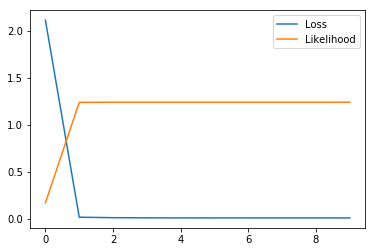

In [19]:
plt.plot(loss_arr, label='Loss')
plt.plot(likelihood_arr, label='Likelihood')
plt.legend()

In [20]:
#np.save('{}/latent_train'.format(Dataset.main),Dataset.latent)

IndexError: index 10 is out of bounds for axis 0 with size 10

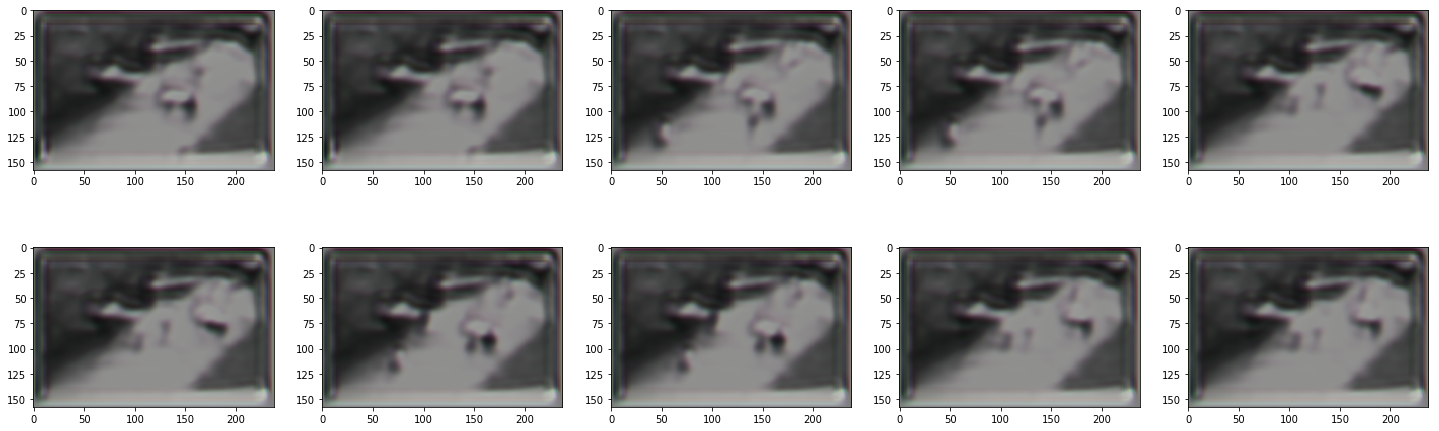

In [21]:
fig, axs = plt.subplots(2,5, figsize=(25,8))
axs = axs.ravel()

for i, imgs in enumerate(Dataset.reproduced_images[:30]):
    axs[i].imshow(imgs[:,:,:])

In [22]:
axs[0].imshow(Dataset.reproduced_images[0,:,:])

In [23]:
Dataset.reproduced_images.shape

(30, 158, 238, 3)

In [24]:
Dataset.reproduced_images[0]

array([[[0.49185196, 0.4944724 , 0.49198592],
        [0.48785755, 0.49433333, 0.48725402],
        [0.48441294, 0.49197853, 0.4838217 ],
        ...,
        [0.49636582, 0.49308962, 0.4950402 ],
        [0.4955052 , 0.49518254, 0.49430215],
        [0.49678147, 0.49637833, 0.49400407]],

       [[0.4888456 , 0.4928326 , 0.48812497],
        [0.48045743, 0.49284846, 0.47493857],
        [0.47170153, 0.48067725, 0.46874678],
        ...,
        [0.49748605, 0.48084342, 0.48830062],
        [0.49704078, 0.49191612, 0.48987123],
        [0.4973465 , 0.4946343 , 0.492312  ]],

       [[0.48722526, 0.4927137 , 0.48593605],
        [0.47283044, 0.49066108, 0.46173584],
        [0.45960835, 0.46731922, 0.4503935 ],
        ...,
        [0.4941108 , 0.46918315, 0.4852089 ],
        [0.49567398, 0.48978513, 0.48716494],
        [0.4985566 , 0.4940199 , 0.4909663 ]],

       ...,

       [[0.49640828, 0.49847177, 0.49675575],
        [0.4893693 , 0.49911478, 0.49033064],
        [0.48759797, 0

In [25]:
Dataset.test_images.shape

(400, 158, 238, 3)

IndexError: index 10 is out of bounds for axis 0 with size 10

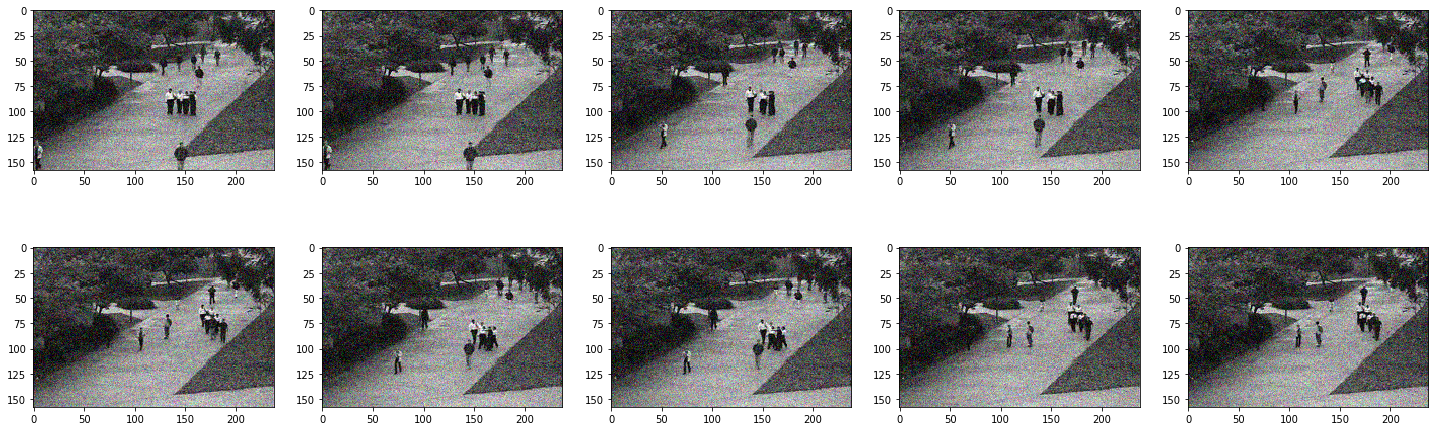

In [26]:
fig, axs = plt.subplots(2,5, figsize=(25,8))
axs = axs.ravel()

for i, imgs in enumerate(Dataset.test_images_[:30]):
    axs[i].imshow(imgs[:,:,:])

In [28]:
Dataset.likelihood

1.2386392